
**Contexte : Le jeu de données Décathlon**    
Le jeu de données Décathlon contient les performances de plusieurs athlètes sur 10 disciplines de l’épreuve du décathlon. Chaque colonne représente une discipline (course, lancer, saut, etc.), et chaque ligne correspond à un athlète.

**Variables disponibles :**

- Épreuves de course : 100m, 400m, 1500m, 110m haies
- Épreuves de saut : Longueur, Hauteur, Perche
- Épreuves de lancer : Poids, Disque, Javelot
- Score total   
💡 Les épreuves sont exprimées en différentes unités (secondes, mètres, points). Une standardisation est nécessaire avant l'ACP.

**Etapes à suivre**
1. Charger le jeu de données "decathlon.csv" et afficher un aperçu des données.
1. Vérifier et traiter les valeurs manquantes si nécessaire.
1. Standardiser les données (moyenne = 0, variance = 1) pour éviter les biais liés aux unités différentes.
1. Appliquer une ACP pour réduire la dimensionnalité des données.
1. Identifier les axes principaux et interpréter les regroupements d’épreuves dans l’espace factoriel.
1. Appliquer l’algorithme K-Means sur les premières composantes principales obtenues.
1. Déterminer le nombre optimal de clusters à l’aide de la méthode du coude.
1. Visualiser les clusters d’athlètes dans l’espace réduit de l’ACP.
1. Interpréter les groupes formés : Quels sont les profils types d’athlètes ? Quelles disciplines sont déterminantes pour la classification ?

In [1]:
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
df = pd.read_csv("data/decathlon.csv")
display(df.head(10))

df.info()

,Athlets,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m,Rank,Points,Competition
0,SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7,1,8217,Decastar
1,CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5,2,8122,Decastar
2,KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2,3,8099,Decastar
3,BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1,4,8067,Decastar
4,YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4,5,8036,Decastar
5,WARNERS,11.11,7.60,14.31,1.98,48.68,14.23,41.10,4.92,51.77,278.1,6,8030,Decastar
6,ZSIVOCZKY,11.13,7.30,13.48,2.01,48.62,14.17,45.67,4.42,55.37,268.0,7,8004,Decastar
7,McMULLEN,10.83,7.31,13.76,2.13,49.91,14.38,44.41,4.42,56.37,285.1,8,7995,Decastar
8,MARTINEAU,11.64,6.81,14.57,1.95,50.14,14.93,47.60,4.92,52.33,262.1,9,7802,Decastar
9,HERNU,11.37,7.56,14.41,1.86,51.10,15.06,44.99,4.82,57.19,285.1,10,7733,Decastar


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlets      41 non-null     object 
 1   100m         41 non-null     float64
 2   Long.jump    41 non-null     float64
 3   Shot.put     41 non-null     float64
 4   High.jump    41 non-null     float64
 5   400m         41 non-null     float64
 6   110m.hurdle  41 non-null     float64
 7   Discus       41 non-null     float64
 8   Pole.vault   41 non-null     float64
 9   Javeline     41 non-null     float64
 10  1500m        41 non-null     float64
 11  Rank         41 non-null     int64  
 12  Points       41 non-null     int64  
 13  Competition  41 non-null     object 
dtypes: float64(10), int64(2), object(2)
memory usage: 4.6+ KB


## Vérification et traitement des valeurs manquantes

In [3]:
print(df.isnull().sum())


Athlets        0
100m           0
Long.jump      0
Shot.put       0
High.jump      0
400m           0
110m.hurdle    0
Discus         0
Pole.vault     0
Javeline       0
1500m          0
Rank           0
Points         0
Competition    0
dtype: int64


## Préparation des données pour l'ACP

In [4]:
athlete_names = df['Athlets'].values

features = ['100m', 'Long.jump', 'Shot.put', 'High.jump', '400m', '110m.hurdle', 'Discus', 'Pole.vault', 'Javeline', '1500m']

df_features = df.drop(['Athlets'], axis=1)
df_features["Competition"] = (df["Competition"] == "Decastar").astype(int)


(df_features.head())

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m,Rank,Points,Competition
0,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7,1,8217,1
1,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5,2,8122,1
2,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2,3,8099,1
3,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1,4,8067,1
4,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4,5,8036,1


In [5]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

df_scaled_df = pd.DataFrame(df_scaled, columns=df_features.columns)
df_scaled_df.head()

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m,Rank,Points,Competition
0,0.161478,1.023937,0.433405,1.060457,0.169981,0.180572,-0.172524,0.937988,1.022196,1.099316,-1.421921,0.625796,1.467599
1,-0.916293,0.447972,-0.266573,-1.329735,-0.216222,-1.192819,1.916555,0.573807,0.384558,1.949271,-1.294073,0.344884,1.467599
2,0.084494,0.127992,0.359723,0.719001,-1.093956,-1.106982,1.386043,0.573807,-1.679377,1.836522,-1.166224,0.276873,1.467599
3,0.084494,-0.095994,-0.278853,-0.646823,-0.602425,0.824348,-1.035731,2.030532,0.934101,0.093246,-1.038376,0.182250,1.467599
4,1.316232,-0.543966,0.875496,1.401913,0.705398,1.511044,0.579784,-0.154555,1.074633,-0.227656,-0.910528,0.090584,1.467599


## Application de l'ACP (Analyse en Composantes Principales)

In [6]:
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print(f"\nNombre de composantes principales: {pca.n_components_}")
print("\nVariance expliquée par chaque composante:")
for i, var in enumerate(explained_variance, 1):
    print(f"  PC{i}: {var*100:.2f}%")


Nombre de composantes principales: 13

Variance expliquée par chaque composante:
  PC1: 36.74%
  PC2: 13.74%
  PC3: 13.05%
  PC4: 10.17%
  PC5: 8.56%
  PC6: 4.74%
  PC7: 4.54%
  PC8: 3.19%
  PC9: 2.26%
  PC10: 1.55%
  PC11: 1.16%
  PC12: 0.30%
  PC13: 0.00%


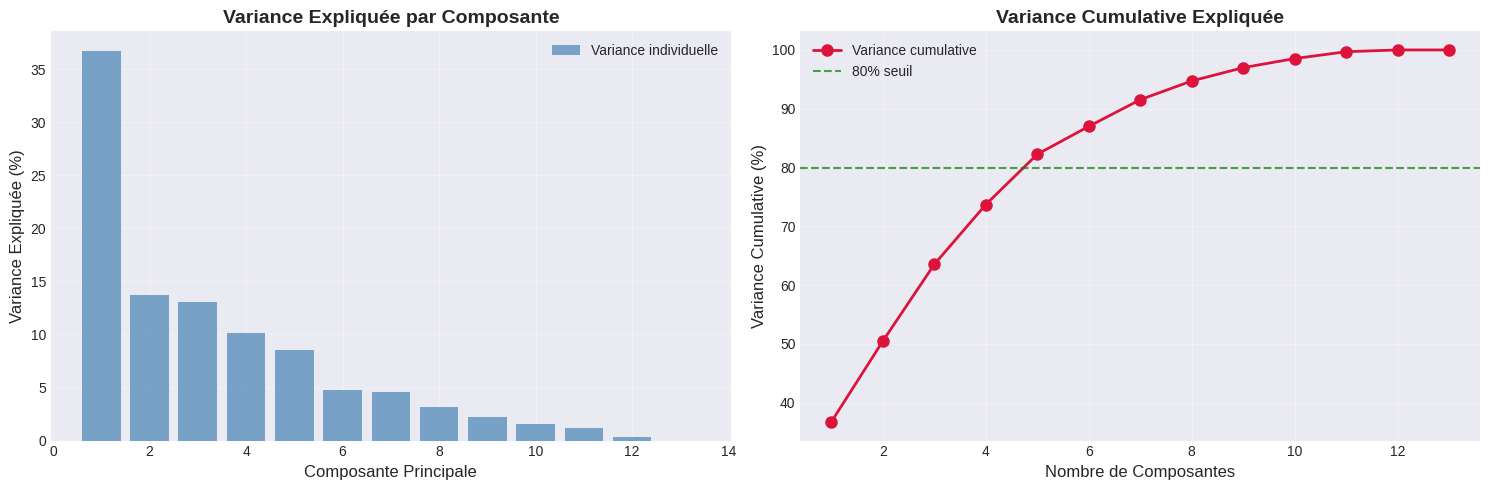


 Critère de Kaiser (valeurs propres > 1): 5 composantes recommandées


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graph 1: Variance individuelle
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance * 100, 
            alpha=0.7, color='steelblue', label='Variance individuelle')
axes[0].set_xlabel('Composante Principale', fontsize=12)
axes[0].set_ylabel('Variance Expliquée (%)', fontsize=12)
axes[0].set_title('Variance Expliquée par Composante', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graph 2: Variance cumulative
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 
             marker='o', markersize=8, color='crimson', linewidth=2, label='Variance cumulative')
axes[1].axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% seuil')
axes[1].set_xlabel('Nombre de Composantes', fontsize=12)
axes[1].set_ylabel('Variance Cumulative (%)', fontsize=12)
axes[1].set_title('Variance Cumulative Expliquée', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

eigenvalues = pca.explained_variance_
n_components_optimal = sum(eigenvalues > 1)
print(f"\n Critère de Kaiser (valeurs propres > 1): {n_components_optimal} composantes recommandées")

## Interprétation des axes principaux - Cercle des corrélations

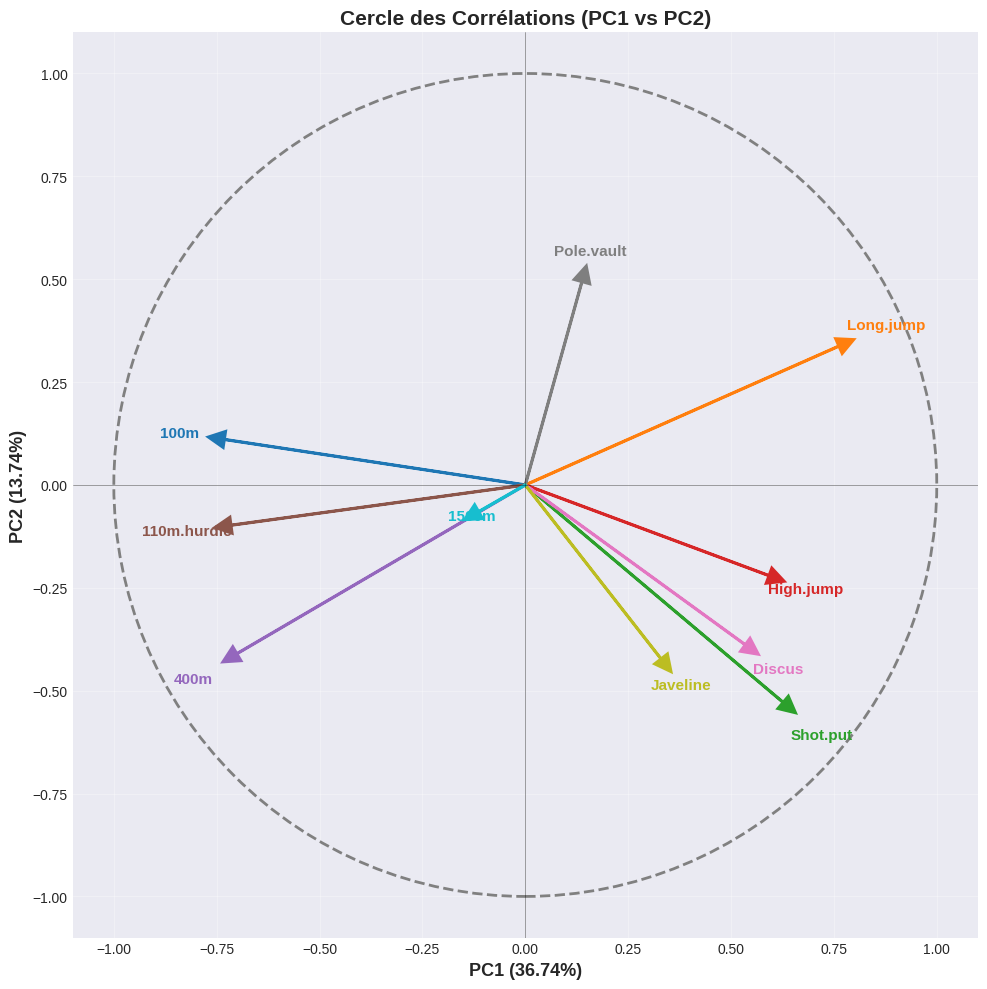

In [8]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(figsize=(10, 10))

circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=2)
ax.add_artist(circle)

colors = plt.cm.tab10(np.linspace(0, 1, len(features)))
for i, (feature, color) in enumerate(zip(features, colors)):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
             head_width=0.04, head_length=0.04, fc=color, ec=color, linewidth=2)
    ax.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature, 
            fontsize=11, ha='center', va='center', fontweight='bold', color=color)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=13, fontweight='bold')
ax.set_title('Cercle des Corrélations (PC1 vs PC2)', fontsize=15, fontweight='bold')
ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [9]:
# Contributions aux 3 premières composantes
contributions = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_features.columns  
)

print("\nContributions des épreuves aux composantes principales:")
display(contributions.round(3))

print("\n Interprétation des axes principaux:")
for i in range(3):
    print(f"\n  PC{i+1} ({explained_variance[i]*100:.2f}% de variance):")
    top_contrib = contributions[f'PC{i+1}'].abs().sort_values(ascending=False).head(3)
    for var, contrib in top_contrib.items():
        sign = "+" if contributions.loc[var, f'PC{i+1}'] > 0 else "-"
        print(f"    {sign} {var}: {abs(contrib):.3f}")


Contributions des épreuves aux composantes principales:


,PC1,PC2,PC3
100m,-0.330,0.082,0.248
Long.jump,0.344,0.249,-0.097
Shot.put,0.283,-0.390,0.263
High.jump,0.268,-0.163,0.209
400m,-0.317,-0.303,0.300
110m.hurdle,-0.323,-0.072,0.148
Discus,0.242,-0.287,0.376
Pole.vault,0.062,0.365,0.198
Javeline,0.149,-0.312,0.008
1500m,-0.051,-0.048,0.500



 Interprétation des axes principaux:

  PC1 (36.74% de variance):
    + Points: 0.450
    - Rank: 0.348
    + Long.jump: 0.344

  PC2 (13.74% de variance):
    + Competition: 0.488
    - Shot.put: 0.390
    + Pole.vault: 0.365

  PC3 (13.05% de variance):
    + 1500m: 0.500
    + Competition: 0.451
    + Discus: 0.376


## Méthode du coude pour déterminer le nombre optimal de clusters

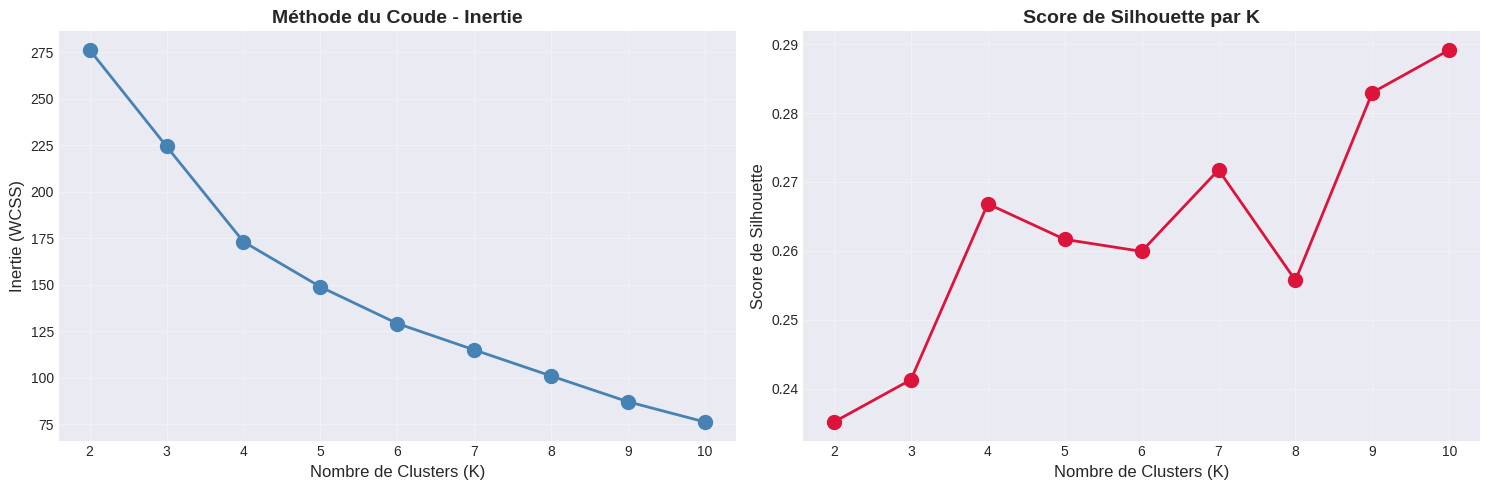


 Nombre optimal de clusters (score de silhouette max): K = 10
   Score de silhouette: 0.289


In [10]:
n_components_for_clustering = 4  
pca_data_for_clustering = pca_components[:, :n_components_for_clustering]

inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_data_for_clustering)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data_for_clustering, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graph 1: Inertie (Within-cluster sum of squares)
axes[0].plot(K_range, inertias, marker='o', markersize=10, linewidth=2, color='steelblue')
axes[0].set_xlabel('Nombre de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertie (WCSS)', fontsize=12)
axes[0].set_title('Méthode du Coude - Inertie', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

# Graph 2: Score de silhouette
axes[1].plot(K_range, silhouette_scores, marker='o', markersize=10, linewidth=2, color='crimson')
axes[1].set_xlabel('Nombre de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Score de Silhouette', fontsize=12)
axes[1].set_title('Score de Silhouette par K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)

plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Nombre optimal de clusters (score de silhouette max): K = {optimal_k}")
print(f"   Score de silhouette: {max(silhouette_scores):.3f}")

## Application de K-Means sur les composantes principales

In [11]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(pca_data_for_clustering)

print(f"\nNombre de clusters: {optimal_k}")
print(f"Score de silhouette: {silhouette_score(pca_data_for_clustering, clusters):.3f}")
print(f"\nRépartition des athlètes par cluster:")
for i in range(optimal_k):
    count = sum(clusters == i)
    print(f"  Cluster {i+1}: {count} athlètes ({count/len(clusters)*100:.1f}%)")


Nombre de clusters: 10
Score de silhouette: 0.289

Répartition des athlètes par cluster:
  Cluster 1: 3 athlètes (7.3%)
  Cluster 2: 6 athlètes (14.6%)
  Cluster 3: 5 athlètes (12.2%)
  Cluster 4: 3 athlètes (7.3%)
  Cluster 5: 6 athlètes (14.6%)
  Cluster 6: 5 athlètes (12.2%)
  Cluster 7: 3 athlètes (7.3%)
  Cluster 8: 2 athlètes (4.9%)
  Cluster 9: 4 athlètes (9.8%)
  Cluster 10: 4 athlètes (9.8%)


## Visualisation des clusters dans l'espace réduit de l'ACP

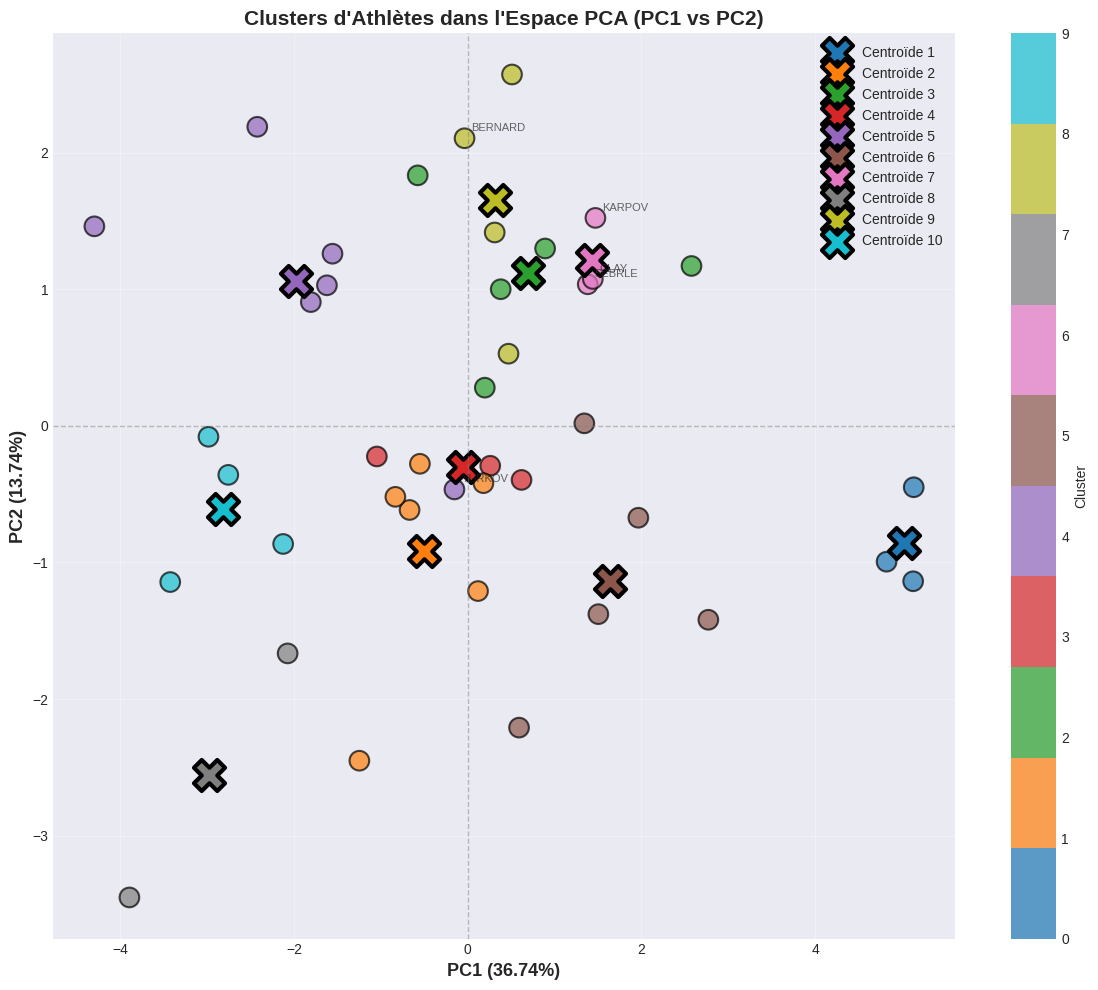

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters, cmap='tab10', s=200, alpha=0.7, 
                     edgecolors='black', linewidth=1.5)

centroids_original = pca.transform(scaler.inverse_transform(scaler.transform(df_features)))[:len(kmeans_final.cluster_centers_)]

centroids_pca = []
for i in range(optimal_k):
    cluster_points = pca_components[clusters == i, :2]
    centroid = cluster_points.mean(axis=0)
    centroids_pca.append(centroid)
    ax.scatter(centroid[0], centroid[1], marker='X', s=500, 
              c=[scatter.cmap(scatter.norm(i))], edgecolors='black', 
              linewidth=3, label=f'Centroïde {i+1}')

for i in range(min(5, len(athlete_names))):
    ax.annotate(athlete_names[i], 
                (pca_components[i, 0], pca_components[i, 1]),
                fontsize=8, alpha=0.7, 
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=13, fontweight='bold')
ax.set_title('Clusters d\'Athlètes dans l\'Espace PCA (PC1 vs PC2)', 
             fontsize=15, fontweight='bold')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')

plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

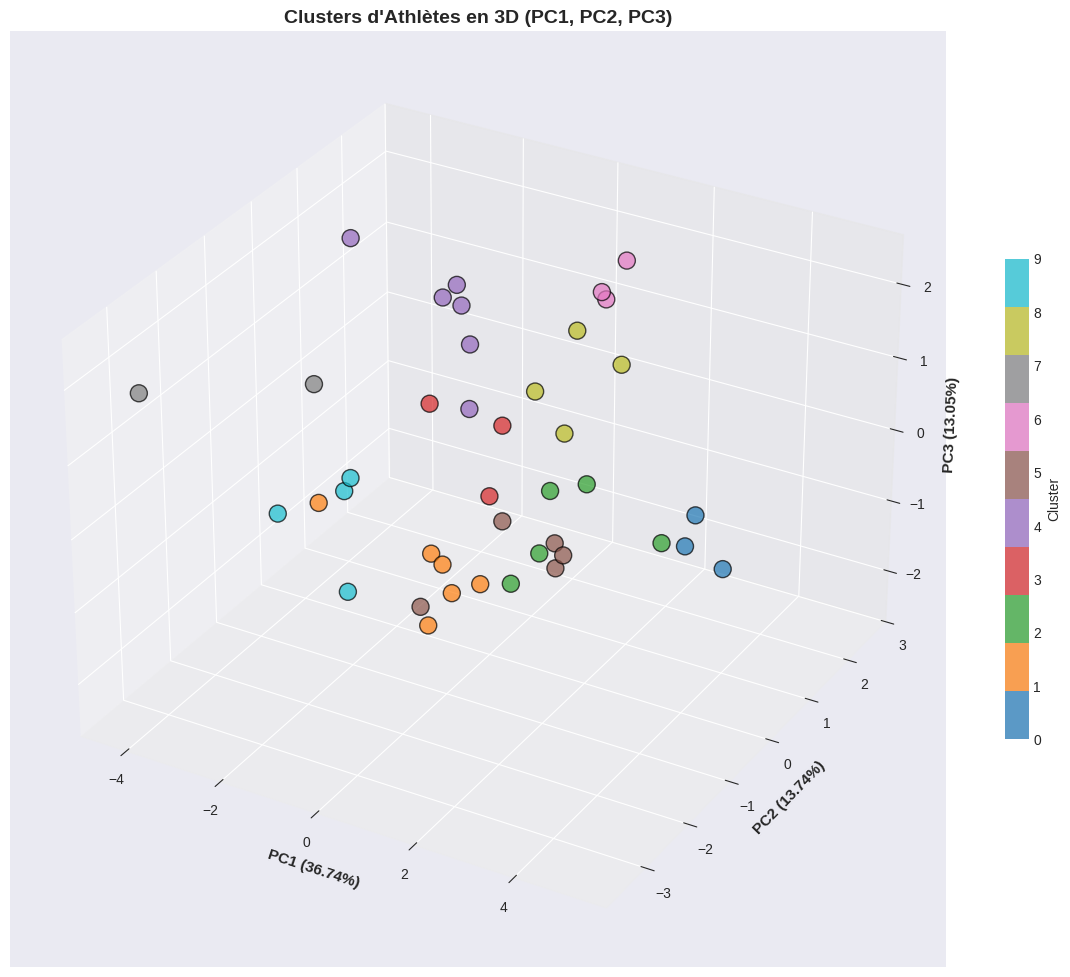

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter_3d = ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2],
                        c=clusters, cmap='tab10', s=150, alpha=0.7, 
                        edgecolors='black', linewidth=1)

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}%)', fontsize=11, fontweight='bold')
ax.set_title('Clusters d\'Athlètes en 3D (PC1, PC2, PC3)', fontsize=14, fontweight='bold')

plt.colorbar(scatter_3d, ax=ax, label='Cluster', shrink=0.5)
plt.tight_layout()
plt.show()